In [1]:
import numpy as np
import pandas as pd
import time
import datetime
import glob, os
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import box
import math
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
import logging
from datetime import datetime

/home/wu.xinh/.conda/envs/ptorch/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
MSA = 'Boston-Cambridge-Newton, MA-NH'
if not os.path.exists(MSA):
    # Create the directory
    os.makedirs(MSA)
    print(f"Directory '{MSA}' has been created.")
else:
    print(f"Directory '{MSA}' already exists.")

Directory 'Boston-Cambridge-Newton, MA-NH' already exists.


# Grid

In [3]:
MSAs=gpd.read_file('/work/rwuirlab/Shapefile_and_Census/MSA_Shapefile/tl_2019_us_cbsa.shp')
CBG_MSA_map=pd.read_csv('/work/rwuirlab/Shapefile_and_Census/CBG_MSA_map.csv',index_col=[0],dtype={'CensusBlockGroup':str,'GEOID':str})

In [4]:
import geopandas as gpd
import geopy.distance
from shapely.geometry import Polygon

def create_grid_within_square(square, km_per_cell=1):
    xmin, ymin, xmax, ymax = square.bounds
    print(xmin, ymin, xmax, ymax)
    dx = geopy.distance.distance(kilometers=km_per_cell).destination((ymin, xmin), bearing=90).longitude - xmin
    dy = geopy.distance.distance(kilometers=km_per_cell).destination((ymin, xmin), bearing=0).latitude - ymin

    x = xmin
    grid_cells = []
    grid_id = 0
    while x < xmax:
        y = ymin
        while y < ymax:
            points = [(x, y), (x + dx, y), (x + dx, y + dy), (x, y + dy)]
            grid_cells.append({"geometry": Polygon(points), "grid_id": f"{grid_id}"})
            y += dy
            grid_id += 1
        x += dx

    # Convert the list of grid cells to a GeoDataFrame
    grid_gdf = gpd.GeoDataFrame(grid_cells, geometry='geometry')
    
    # Assuming the use of WGS84 latitude and longitude (EPSG:4326)
    grid_gdf.crs = "EPSG:4326"
    
    return grid_gdf

In [5]:
geometry = MSAs[MSAs['NAME']==MSA].geometry.values[0]

In [6]:
gdf_1km = create_grid_within_square(geometry, km_per_cell=1)

-71.89877299999999 41.565850999999995 -70.32252199999999 43.572787


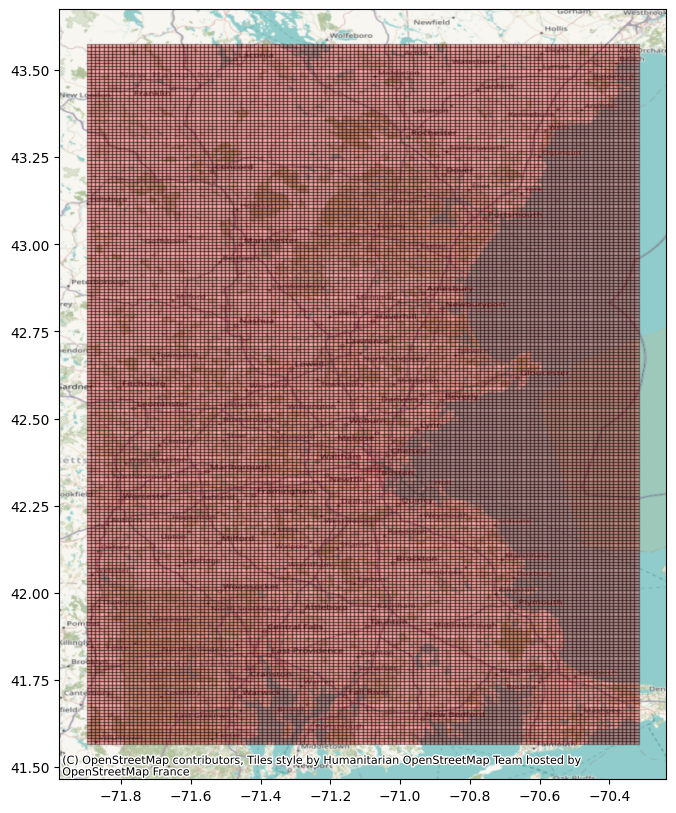

In [7]:
import matplotlib.pyplot as plt
import contextily as ctx
fig, ax = plt.subplots(figsize=(10, 10))
gdf_1km.plot(ax=ax, color='red', alpha=0.3, edgecolor='black')  # 1km 网格
gdf_1km.crs = "EPSG:4326"
ctx.add_basemap(ax, crs=gdf_1km.crs.to_string())  # 添加底图

gdf_1km.to_file(filename=f"{MSA}/{MSA}.geojson", driver='GeoJSON')
fig.savefig(f"{MSA}/{MSA}.png")

# Extract

In [8]:
file_path = f'/work/rwuirlab/COVID_Cuebiq_MSA_Ind/{MSA}'
import re
file_path = re.sub(r"\s+", "", file_path)

In [9]:
csv_files = glob.glob(os.path.join(file_path, '*.csv'))

In [10]:
len(csv_files)

1136234

In [11]:
output_path = f'{MSA}/cache.csv'
os.remove(output_path)

In [12]:
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor, as_completed
import pandas as pd
import os
from tqdm import tqdm

def process_csv_file(csv):
    # Placeholder for the processing logic
    # Replace this with your actual data processing code
    df = pd.read_csv(csv, header=None)
    df.columns = ['time', 'latitude', 'longitude', 'acc']
    
    df['time'] = pd.to_datetime(df['time'])
    start_date = pd.Timestamp('2020-02-02 00:00:00')
    end_date = pd.Timestamp('2020-02-17 23:59:59')
    df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]
    
    # Add further processing steps here
    sorted_df = df.sort_values(by=['time'])

    sorted_df['month'] = sorted_df['time'].dt.month
    sorted_df['day'] = sorted_df['time'].dt.day
    sorted_df['20min_id'] = sorted_df['time'].dt.hour * 3 + sorted_df['time'].dt.minute // 20
    
    sorted_df = gpd.GeoDataFrame(sorted_df, geometry=[Point(xy) for xy in zip(sorted_df.longitude, sorted_df.latitude)])
    sorted_df.crs = gdf_1km.crs
    
    merged_gdf = gpd.sjoin(sorted_df, gdf_1km, how="left", op='within')
    # merged_gdf['grid_id'] = merged_gdf['grid_id'].fillna(-1)
    merged_gdf = merged_gdf[~merged_gdf.grid_id.isna()]
    merged_gdf = merged_gdf.drop_duplicates(['month','day','20min_id','grid_id'])   
    
    
    # merged_gdf['next_grid_id'] = merged_gdf['grid_id'].shift(-1)
    
    # merged_gdf = merged_gdf[(merged_gdf.grid_id!=merged_gdf.next_grid_id)|(merged_gdf.grid_id==-1)]
    merged_gdf = merged_gdf[['month','day','20min_id','grid_id']]
    
    return merged_gdf

def write_to_csv(dataframe, output_path, mode='a', header=False):
    if not os.path.exists(output_path) or mode == 'w':
        header = True
    dataframe.to_csv(output_path, mode=mode, header=header, index=False)

# Main processing function that uses parallel execution
def main(csv_files, output_path):
    batch_size = 10  
    batch_data = []
    
    with ProcessPoolExecutor() as executor:
        future_to_csv = {executor.submit(process_csv_file, csv): csv for csv in csv_files}
        
        for future in tqdm(as_completed(future_to_csv), total=len(csv_files), desc="Processing files"):
            df = future.result()
            batch_data.append(df)
            
            if len(batch_data) >= batch_size:
                concatenated_df = pd.concat(batch_data, ignore_index=True)
                write_to_csv(concatenated_df, output_path)
                batch_data = []  

    if batch_data:
        concatenated_df = pd.concat(batch_data, ignore_index=True)
        write_to_csv(concatenated_df, output_path)

    


# def main(csv_files, output_path):
#     batch_size = 10  # Adjust based on your needs
#     batch_data = []
    
#     for csv in tqdm(csv_files, desc="Processing files"):
#         df = process_csv_file(csv)
#         batch_data.append(df)
        
#         if len(batch_data) >= batch_size:
#             concatenated_df = pd.concat(batch_data, ignore_index=True)
#             write_to_csv(concatenated_df, output_path)
#             batch_data = []  # Reset for the next batch

#     # Handle any remaining files in the last batch
#     if batch_data:
#         concatenated_df = pd.concat(batch_data, ignore_index=True)
#         write_to_csv(concatenated_df, output_path)

In [13]:
def setup_logging(log_path):
    logging.basicConfig(filename=log_path, level=logging.INFO,
                        format='%(asctime)s - %(levelname)s - %(message)s',
                        datefmt='%Y-%m-%d %H:%M:%S')

In [14]:
log_path = f'{MSA}/process.log'
setup_logging(log_path)
logging.info(f"Begin processing files")
main(csv_files, output_path)
# logging.info(f"End processing files")

Processing files: 100%|██████████| 1136234/1136234 [2:43:27<00:00, 115.86it/s] 
